In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrices, dmatrix
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import numpy as np
#from keras.utils import to_categorical
#from keras.models import Sequential
#from keras.layers import Dense, Activation
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

seed = 5
np.random.seed(seed)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [68]:
lc_2015 = pd.read_csv('lc_2015.csv', header=1, low_memory=False)
lc_2015_dec = pd.read_csv('lc_2015_dec.csv', header=1, low_memory=False)

In [126]:
# Load pickles

file = open('prob_A_model', 'rb')
logistic_A = pickle.load(file)
file.close()

In [69]:
lc_2015['grade'].value_counts()

C    120567
B    117606
A     73336
D     62654
E     34948
F      9817
G      2167
Name: grade, dtype: int64

In [70]:
# Replicate Jeremy's column

from datetime import datetime

days_since_last_credit_pull_d = []
for i in lc_2015['last_credit_pull_d']:
    try:
        temp_date = datetime.strptime(i, '%b-%Y')
        days_since_last_credit_pull_d.append((datetime.today() - temp_date).days)
    except:
        days_since_last_credit_pull_d.append(0)
        
lc_2015['days_since_last_credit_pull_d'] = days_since_last_credit_pull_d

In [71]:
#lc_d_2015 = lc_2015[((lc_2015['loan_status']=='Fully Paid') | (lc_2015['loan_status']=='Charged Off'))].copy()

lc_d_2015 = lc_2015[((lc_2015['grade']=='D')
                   | (lc_2015['grade']=='E'))
                   #| (lc_2015['grade']=='F')
                   #| (lc_2015['grade']=='G'))
                   & (lc_2015['term']==' 36 months')
                   & ((lc_2015['loan_status']=='Fully Paid') | (lc_2015['loan_status']=='Charged Off'))
                  ].copy()

lc_d_2015.reset_index(inplace=True)

In [72]:
lc_d_2015['loan_status'].value_counts()/np.sum(lc_d_2015['loan_status'].value_counts())

Fully Paid     0.722968
Charged Off    0.277032
Name: loan_status, dtype: float64

In [73]:
lc_d_2015['loan_status'].value_counts()

Fully Paid     30476
Charged Off    11678
Name: loan_status, dtype: int64

In [74]:
# Clean up the dataframe

# Make my outcome variable 0s and 1s
outcome_var = []
for i in lc_d_2015['loan_status']:
    if i == 'Charged Off':
        outcome_var.append(1)
    else:
        outcome_var.append(0)
lc_d_2015['outcome_var'] = outcome_var

# Find all the mths_since columns
mths_since_list = [i for i in lc_d_2015.columns if 'mths_since' in i]

# Bin the mths_since columns to make them valid inputs
for col in mths_since_list:
    if col != 'sec_app_mths_since_last_major_derog':
        category = list(pd.cut(lc_d_2015[col], bins=4, labels=['0', '1', '2', '3']))
        for i, val in enumerate(category):
            if type(val) != str:
                if np.isnan(val):
                    category[i] = '4'
    lc_d_2015[col + '_cat'] = category
    
# Replace nulls in columns with strings (i.e. if no job title, replace null with 'none')
ok_list = ['emp_title','emp_length']
for col in ok_list:
    new_list = []
    col_values = list(lc_d_2015[col])
    for i, val in enumerate(col_values):
        if type(val) != str:
            if np.isnan(val):
                new_list.append('none')
            else:
                new_list.append(val)
        else:
            new_list.append(val)
    new_col_name = col + '_2'
    lc_d_2015[new_col_name] = new_list

In [75]:
# Count the nulls for each column and store each count in a dictionary (keys = column name)
def count_null(df):
    null_dict = {}
    for i in df.columns:
        if i in null_dict:
            null_dict[i] += sum([1 for j in lc_d_2015[i].isna() if j])
        else:
            null_dict[i] = sum([1 for j in lc_d_2015[i].isna() if j])
    return null_dict

null_dict = count_null(lc_d_2015)

In [76]:
# Check df shape before dropping nulls
lc_d_2015.shape

(42154, 159)

In [77]:
# Drop nulls
for key, val in null_dict.items():
    if val >= 5000:
        lc_d_2015.drop(labels=key, axis=1, inplace=True)
        
null_dict2 = count_null(lc_d_2015)

lc_d_2015.dropna(inplace=True)
lc_d_2015.shape

(30974, 101)

In [78]:
lc_d_2015['loan_status'].value_counts()

Fully Paid     22449
Charged Off     8525
Name: loan_status, dtype: int64

In [79]:
null_dict

{'index': 0,
 'id': 42154,
 'member_id': 42154,
 'loan_amnt': 0,
 'funded_amnt': 0,
 'funded_amnt_inv': 0,
 'term': 0,
 'int_rate': 0,
 'installment': 0,
 'grade': 0,
 'sub_grade': 0,
 'emp_title': 3812,
 'emp_length': 3803,
 'home_ownership': 0,
 'annual_inc': 0,
 'verification_status': 0,
 'issue_d': 0,
 'loan_status': 0,
 'pymnt_plan': 0,
 'url': 42154,
 'desc': 42151,
 'purpose': 0,
 'title': 8,
 'zip_code': 0,
 'addr_state': 0,
 'dti': 1,
 'delinq_2yrs': 0,
 'earliest_cr_line': 0,
 'inq_last_6mths': 0,
 'mths_since_last_delinq': 19391,
 'mths_since_last_record': 32398,
 'open_acc': 0,
 'pub_rec': 0,
 'revol_bal': 0,
 'revol_util': 42,
 'total_acc': 0,
 'initial_list_status': 0,
 'out_prncp': 0,
 'out_prncp_inv': 0,
 'total_pymnt': 0,
 'total_pymnt_inv': 0,
 'total_rec_prncp': 0,
 'total_rec_int': 0,
 'total_rec_late_fee': 0,
 'recoveries': 0,
 'collection_recovery_fee': 0,
 'last_pymnt_d': 81,
 'last_pymnt_amnt': 0,
 'next_pymnt_d': 42154,
 'last_credit_pull_d': 1,
 'collections_1

In [80]:
#Include?        	LoanStatNew
#Keep for agg    	id
#Maybe           	last_pymnt_amnt
#Maybe           	last_pymnt_d
#Outcome         	loan_status
#Keep for agg    	member_id
#Maybe           	sub_grade
#Category        	zip_code
#Like Outcome    	debt_settlement_flag
store_list = ['last_pymnt_amnt','last_pymnt_d','loan_status','sub_grade','zip_code','debt_settlement_flag']
kept_df = lc_d_2015[store_list].copy()

remove_list = ['collection_recovery_fee',
               #'grade',                  # <- decided to keep grade in
               'initial_list_status',
               'next_pymnt_d',
               'policy_code',
               'title',
               'url',
               'payment_plan_start_date',
               'orig_projected_additional_accrued_interest',
               'debt_settlement_flag_date',
               'settlement_date']

for i in remove_list:
    if i in lc_d_2015.columns:
        lc_d_2015.drop(labels=i, axis=1, inplace=True)

In [81]:
lc_d_2015.groupby(by=['loan_status','sub_grade']).count()['int_rate']

loan_status  sub_grade
Charged Off  D1           1597
             D2           1413
             D3           1231
             D4           1034
             D5            914
             E1            738
             E2            566
             E3            486
             E4            321
             E5            225
Fully Paid   D1           5436
             D2           4060
             D3           3477
             D4           2577
             D5           2185
             E1           1640
             E2           1221
             E3            910
             E4            564
             E5            379
Name: int_rate, dtype: int64

                               days_since_last_credit_pull_d  outcome_var
days_since_last_credit_pull_d                       1.000000     0.337996
outcome_var                                         0.337996     1.000000


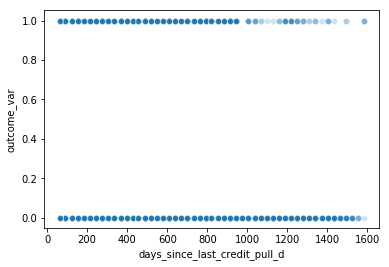

In [82]:
var_x_str = 'days_since_last_credit_pull_d'
var_y_str = 'outcome_var'
sns.scatterplot(x=var_x_str, y=var_y_str, data=lc_d_2015, alpha=0.2);
print(lc_d_2015[[var_x_str, var_y_str]].corr())

In [83]:
# More cleaning and feature engineering

convert_list = ['int_rate','revol_util']
for col in convert_list:
    new_list = []
    new_name = col + '_float'
    for i in lc_d_2015[col]:
        if col != 'revol_util':
            new_list.append(float(re.findall(r'\d+\.\d+', i)[0])/100)
        else:
            new_list.append(float(re.findall(r'\d+', i)[0])/100)
    lc_d_2015[new_name] = new_list

emp_length_int = []
for i in lc_d_2015['emp_length_2']:
    if i == 'none':
        emp_length_int.append(0)
    else:
        emp_length_int.append(int(re.findall(r'\d+', i)[0]))
lc_d_2015['emp_length_int'] = emp_length_int

earliest_cr_yrs = []
for i in lc_d_2015['earliest_cr_line']:
    earliest_cr_yrs.append(2019 - int(re.findall(r'\d+', i)[0]))
lc_d_2015['earliest_cr_yrs'] = earliest_cr_yrs

In [84]:
# Things to try:
# Use zip code to figure out if the borrower lives in urban area or not.  Also high income area or not.
# Try to figure out how to use job title (emp_title_2)
#    (maybe if the salary is really different from the avg salary for the job title, then it indicates lying)
# Use earliest_cr_line to calculate the borrower's age

# Figure out the features I want in my model
model_cols = ['outcome_var',
              #'grade',
              #'days_since_last_credit_pull_d',  <- this variable has forward looking bias
              'sub_grade',
              'loan_amnt', 'int_rate_float', 'home_ownership', 'annual_inc',
              'verification_status', 'issue_d', 'purpose', 'addr_state', 
              'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
              'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
              'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
              'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
              'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
              'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
              'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
              'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
              'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
              'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
              'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
              'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
              'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

model_data = lc_d_2015[model_cols].copy()

In [85]:
# Cluster Analysis

from sklearn.cluster import KMeans

cluster_cols = ['emp_length_int', 'annual_inc', 'verification_status', 'purpose', 'home_ownership']

# Add interactions
cluster_str = cluster_cols[0]
for i in cluster_cols[1:]:
    cluster_str = cluster_str + ' + ' + i

cluster_patsy = dmatrix(cluster_str, model_data)

cluster_model = KMeans(n_clusters=5)
cluster_model.fit(cluster_patsy)
my_clusters = ['group_' + str(i) for i in cluster_model.labels_]

model_data['my_clusters'] = my_clusters

In [87]:
# Use Patsy to create my X Matrix 
x_cols = ['my_clusters',
          #'grade',
          #'days_since_last_credit_pull_d',
          'sub_grade',
          'loan_amnt', 'int_rate_float', 'home_ownership', 'annual_inc',
          'verification_status', 'issue_d', 'purpose', 'addr_state', 
          'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
          'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
          'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
          'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
          'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
          'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
          'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
          'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
          'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
          'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
          'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
          'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
          'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '+ loan_amnt*int_rate_float'

x_patsy = dmatrix(x_str, model_data)
print(x_patsy.shape)

(30974, 162)


In [130]:
prob_A = logistic_A.predict_proba(x_patsy)[:,1]
model_data['prob_A'] = prob_A

In [131]:
# Second patsy matrix that includes the new prob_A engineered feature (looks redundant but it is not)

x_cols = ['my_clusters',
          'prob_A',        # This is a new custom variable generated in another file
          'sub_grade',
          'loan_amnt', 'int_rate_float', 'home_ownership', 'annual_inc',
          'verification_status', 'issue_d', 'purpose', 'addr_state', 
          'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
          'revol_bal', 'revol_util_float', 'total_acc', 'collections_12_mths_ex_med',
          'acc_now_delinq', 'tot_coll_amt', 'total_rev_hi_lim', 'acc_open_past_24mths', 
          'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'delinq_amnt',
          'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
          'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
          'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts',
          'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
          'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
          'total_bc_limit', 'total_il_high_credit_limit', 'mths_since_last_delinq_cat',
          'mths_since_last_record_cat', 'mths_since_last_major_derog_cat', 'mths_since_rcnt_il_cat',
          'mths_since_recent_bc_cat', 'mths_since_recent_bc_dlq_cat', 'mths_since_recent_inq_cat',
          'mths_since_recent_revol_delinq_cat', 'emp_length_int', 'earliest_cr_yrs']

# Add interactions
x_str = x_cols[0]
for i in x_cols[1:]:
    x_str = x_str + ' + ' + i
x_str = x_str + '+ loan_amnt*int_rate_float'

x_patsy = dmatrix(x_str, model_data)
print(x_patsy.shape)

(30974, 163)


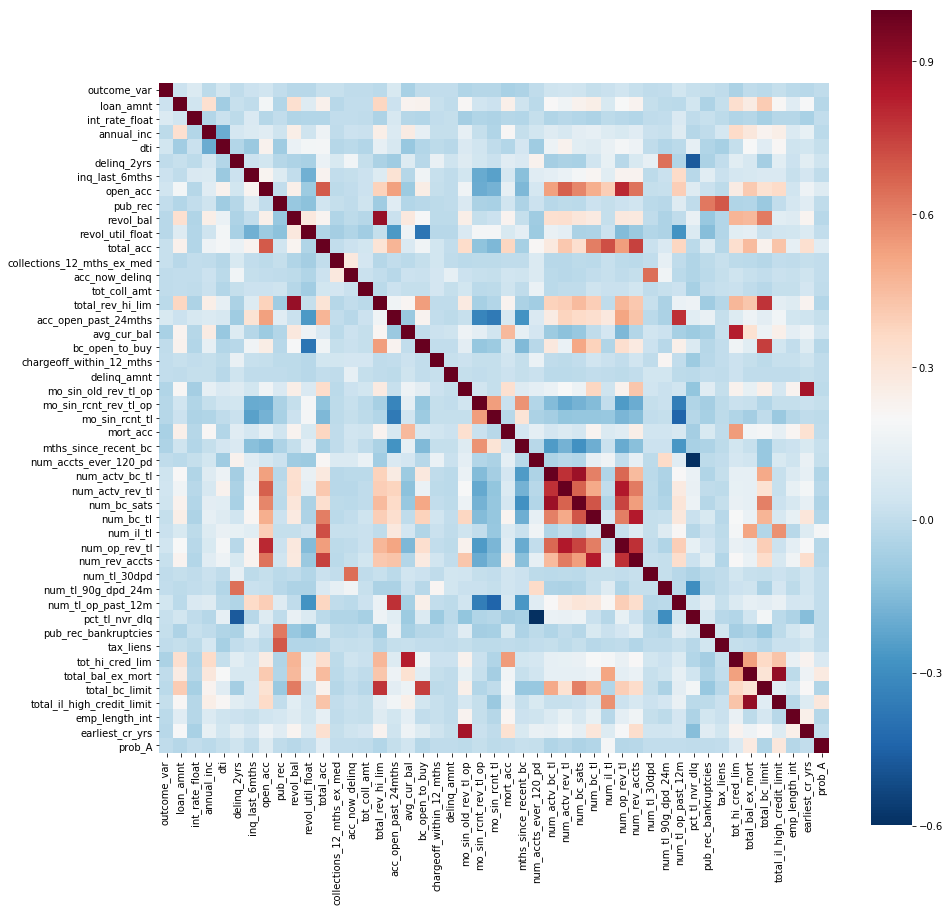

In [151]:
# Plot the correlation matrix
corrs = model_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corrs, square=True, cmap="RdBu_r");
plt.savefig(fname='corr_matrix', dpi=150)

In [132]:
# Shuffle and then train/test split of my variables
# from sklearn.utils import shuffle

# x_raw = x_patsy
# y_raw = model_data['outcome_var']

#x_shuffle, y_shuffle = shuffle(x_raw, y_raw)
#x_mid, x_test, y_mid, y_test = train_test_split(x_shuffle, y_shuffle, test_size=0.2, random_state=0)
#x_train, x_val, y_train, y_val = train_test_split(x_mid, y_mid, test_size=0.25, random_state=0)

# Stratified train test split
x_raw = x_patsy
y_raw = np.array(model_data['outcome_var'])

sss1 = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss2 = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=0)

sss1.get_n_splits()
for train_index, test_index in sss1.split(x_raw, y_raw):
    x_mid, x_test = x_raw[train_index,:], x_raw[test_index,:]
    y_mid, y_test = y_raw[train_index], y_raw[test_index]

sss2.get_n_splits()
for train_index, test_index in sss2.split(x_mid, y_mid):
    x_train, x_val = x_mid[train_index,:], x_mid[test_index,:]
    y_train, y_val = y_mid[train_index], y_mid[test_index]

In [133]:
# Normalize my variables
scaler = StandardScaler()
scaler.fit(x_train)
x_norm_train = scaler.transform(x_train)
x_norm_val = scaler.transform(x_val)
x_norm_test = scaler.transform(x_test)

In [134]:
x_norm_test.shape

(6195, 163)

In [135]:
# Run CV with 5 folds (knn)

# ks = [501]
# param_grid = [{'n_neighbors': ks}]

# knn = KNeighborsClassifier()
# knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
# knn_grid.fit(x_norm_train, y_train)

In [136]:
# Run CV with 5 folds (logit)

penalty = ['l2']
C = np.logspace(0, 4, 10, 100, 1000)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e+00, 2.15443e+01, 4.64159e+02, 1.00000e+04, 2.15443e+05,
       4.64159e+06, 1.00000e+08, 2.15443e+09, 4.64159e+10, 1.00000e+12]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [137]:
# Run CV with 5 folds (SVM)

# C = [1]
# gammas = [0.001, 0.1]
# param_grid = dict(C=C, gamma=gammas)

# svm1 = svm.SVC(kernel='rbf', probability=True)
# svm_grid = GridSearchCV(svm1, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
# svm_grid.fit(x_norm_train, y_train)

In [138]:
# Fit a Naive Bayes Model

gnb = GaussianNB()
gnb_best = gnb.fit(x_norm_train, y_train)

In [94]:
# Run CV with 5 folds (Random Forest)

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt'],
    'min_samples_leaf': [5, 10],
    'min_samples_split': [5, 10],
    'n_estimators': [300, 500, 700]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(x_norm_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 18

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 20, 30], 'max_features': ['sqrt'], 'min_samples_leaf': [5, 10], 'min_samples_split': [5, 10], 'n_estimators': [300, 500, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [139]:
# Train a neural network that doesn't crash your kernel

# n_cols = x_norm_val.shape[1]
# nn_model = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(n_cols,100))

# nn_model.fit(x_norm_train, y_train)

In [140]:
# Bagging

bagging_logit = BaggingClassifier(linear_model.LogisticRegression(solver='lbfgs', max_iter=10000), 
                                  n_estimators=1000, max_samples=0.50, max_features=0.80, verbose=10)
bagging_logit.fit(x_norm_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 1000 for this parallel run (total 1000)...
Building estimator 2 of 1000 for this parallel run (total 1000)...
Building estimator 3 of 1000 for this parallel run (total 1000)...
Building estimator 4 of 1000 for this parallel run (total 1000)...
Building estimator 5 of 1000 for this parallel run (total 1000)...
Building estimator 6 of 1000 for this parallel run (total 1000)...
Building estimator 7 of 1000 for this parallel run (total 1000)...
Building estimator 8 of 1000 for this parallel run (total 1000)...
Building estimator 9 of 1000 for this parallel run (total 1000)...
Building estimator 10 of 1000 for this parallel run (total 1000)...
Building estimator 11 of 1000 for this parallel run (total 1000)...
Building estimator 12 of 1000 for this parallel run (total 1000)...
Building estimator 13 of 1000 for this parallel run (total 1000)...
Building estimator 14 of 1000 for this parallel run (total 1000)...
Building estimator 15 of 1000 for this parallel run (tota

Building estimator 122 of 1000 for this parallel run (total 1000)...
Building estimator 123 of 1000 for this parallel run (total 1000)...
Building estimator 124 of 1000 for this parallel run (total 1000)...
Building estimator 125 of 1000 for this parallel run (total 1000)...
Building estimator 126 of 1000 for this parallel run (total 1000)...
Building estimator 127 of 1000 for this parallel run (total 1000)...
Building estimator 128 of 1000 for this parallel run (total 1000)...
Building estimator 129 of 1000 for this parallel run (total 1000)...
Building estimator 130 of 1000 for this parallel run (total 1000)...
Building estimator 131 of 1000 for this parallel run (total 1000)...
Building estimator 132 of 1000 for this parallel run (total 1000)...
Building estimator 133 of 1000 for this parallel run (total 1000)...
Building estimator 134 of 1000 for this parallel run (total 1000)...
Building estimator 135 of 1000 for this parallel run (total 1000)...
Building estimator 136 of 1000 for

Building estimator 241 of 1000 for this parallel run (total 1000)...
Building estimator 242 of 1000 for this parallel run (total 1000)...
Building estimator 243 of 1000 for this parallel run (total 1000)...
Building estimator 244 of 1000 for this parallel run (total 1000)...
Building estimator 245 of 1000 for this parallel run (total 1000)...
Building estimator 246 of 1000 for this parallel run (total 1000)...
Building estimator 247 of 1000 for this parallel run (total 1000)...
Building estimator 248 of 1000 for this parallel run (total 1000)...
Building estimator 249 of 1000 for this parallel run (total 1000)...
Building estimator 250 of 1000 for this parallel run (total 1000)...
Building estimator 251 of 1000 for this parallel run (total 1000)...
Building estimator 252 of 1000 for this parallel run (total 1000)...
Building estimator 253 of 1000 for this parallel run (total 1000)...
Building estimator 254 of 1000 for this parallel run (total 1000)...
Building estimator 255 of 1000 for

Building estimator 361 of 1000 for this parallel run (total 1000)...
Building estimator 362 of 1000 for this parallel run (total 1000)...
Building estimator 363 of 1000 for this parallel run (total 1000)...
Building estimator 364 of 1000 for this parallel run (total 1000)...
Building estimator 365 of 1000 for this parallel run (total 1000)...
Building estimator 366 of 1000 for this parallel run (total 1000)...
Building estimator 367 of 1000 for this parallel run (total 1000)...
Building estimator 368 of 1000 for this parallel run (total 1000)...
Building estimator 369 of 1000 for this parallel run (total 1000)...
Building estimator 370 of 1000 for this parallel run (total 1000)...
Building estimator 371 of 1000 for this parallel run (total 1000)...
Building estimator 372 of 1000 for this parallel run (total 1000)...
Building estimator 373 of 1000 for this parallel run (total 1000)...
Building estimator 374 of 1000 for this parallel run (total 1000)...
Building estimator 375 of 1000 for

Building estimator 480 of 1000 for this parallel run (total 1000)...
Building estimator 481 of 1000 for this parallel run (total 1000)...
Building estimator 482 of 1000 for this parallel run (total 1000)...
Building estimator 483 of 1000 for this parallel run (total 1000)...
Building estimator 484 of 1000 for this parallel run (total 1000)...
Building estimator 485 of 1000 for this parallel run (total 1000)...
Building estimator 486 of 1000 for this parallel run (total 1000)...
Building estimator 487 of 1000 for this parallel run (total 1000)...
Building estimator 488 of 1000 for this parallel run (total 1000)...
Building estimator 489 of 1000 for this parallel run (total 1000)...
Building estimator 490 of 1000 for this parallel run (total 1000)...
Building estimator 491 of 1000 for this parallel run (total 1000)...
Building estimator 492 of 1000 for this parallel run (total 1000)...
Building estimator 493 of 1000 for this parallel run (total 1000)...
Building estimator 494 of 1000 for

Building estimator 600 of 1000 for this parallel run (total 1000)...
Building estimator 601 of 1000 for this parallel run (total 1000)...
Building estimator 602 of 1000 for this parallel run (total 1000)...
Building estimator 603 of 1000 for this parallel run (total 1000)...
Building estimator 604 of 1000 for this parallel run (total 1000)...
Building estimator 605 of 1000 for this parallel run (total 1000)...
Building estimator 606 of 1000 for this parallel run (total 1000)...
Building estimator 607 of 1000 for this parallel run (total 1000)...
Building estimator 608 of 1000 for this parallel run (total 1000)...
Building estimator 609 of 1000 for this parallel run (total 1000)...
Building estimator 610 of 1000 for this parallel run (total 1000)...
Building estimator 611 of 1000 for this parallel run (total 1000)...
Building estimator 612 of 1000 for this parallel run (total 1000)...
Building estimator 613 of 1000 for this parallel run (total 1000)...
Building estimator 614 of 1000 for

Building estimator 719 of 1000 for this parallel run (total 1000)...
Building estimator 720 of 1000 for this parallel run (total 1000)...
Building estimator 721 of 1000 for this parallel run (total 1000)...
Building estimator 722 of 1000 for this parallel run (total 1000)...
Building estimator 723 of 1000 for this parallel run (total 1000)...
Building estimator 724 of 1000 for this parallel run (total 1000)...
Building estimator 725 of 1000 for this parallel run (total 1000)...
Building estimator 726 of 1000 for this parallel run (total 1000)...
Building estimator 727 of 1000 for this parallel run (total 1000)...
Building estimator 728 of 1000 for this parallel run (total 1000)...
Building estimator 729 of 1000 for this parallel run (total 1000)...
Building estimator 730 of 1000 for this parallel run (total 1000)...
Building estimator 731 of 1000 for this parallel run (total 1000)...
Building estimator 732 of 1000 for this parallel run (total 1000)...
Building estimator 733 of 1000 for

Building estimator 839 of 1000 for this parallel run (total 1000)...
Building estimator 840 of 1000 for this parallel run (total 1000)...
Building estimator 841 of 1000 for this parallel run (total 1000)...
Building estimator 842 of 1000 for this parallel run (total 1000)...
Building estimator 843 of 1000 for this parallel run (total 1000)...
Building estimator 844 of 1000 for this parallel run (total 1000)...
Building estimator 845 of 1000 for this parallel run (total 1000)...
Building estimator 846 of 1000 for this parallel run (total 1000)...
Building estimator 847 of 1000 for this parallel run (total 1000)...
Building estimator 848 of 1000 for this parallel run (total 1000)...
Building estimator 849 of 1000 for this parallel run (total 1000)...
Building estimator 850 of 1000 for this parallel run (total 1000)...
Building estimator 851 of 1000 for this parallel run (total 1000)...
Building estimator 852 of 1000 for this parallel run (total 1000)...
Building estimator 853 of 1000 for

Building estimator 959 of 1000 for this parallel run (total 1000)...
Building estimator 960 of 1000 for this parallel run (total 1000)...
Building estimator 961 of 1000 for this parallel run (total 1000)...
Building estimator 962 of 1000 for this parallel run (total 1000)...
Building estimator 963 of 1000 for this parallel run (total 1000)...
Building estimator 964 of 1000 for this parallel run (total 1000)...
Building estimator 965 of 1000 for this parallel run (total 1000)...
Building estimator 966 of 1000 for this parallel run (total 1000)...
Building estimator 967 of 1000 for this parallel run (total 1000)...
Building estimator 968 of 1000 for this parallel run (total 1000)...
Building estimator 969 of 1000 for this parallel run (total 1000)...
Building estimator 970 of 1000 for this parallel run (total 1000)...
Building estimator 971 of 1000 for this parallel run (total 1000)...
Building estimator 972 of 1000 for this parallel run (total 1000)...
Building estimator 973 of 1000 for

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min finished


BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.8,
         max_samples=0.5, n_estimators=1000, n_jobs=None, oob_score=False,
         random_state=None, verbose=10, warm_start=False)

In [97]:
# Gradient Boosting

# params = {'n_estimators': 500,
#           'max_leaf_nodes': 5, 
#           'max_depth': None, 
#           'min_samples_split': 5,
#           'learning_rate': 0.1, 
#           'subsample': 0.20}

# gboost = GradientBoostingClassifier(**params)
# gboost.fit(x_norm_train, y_train)

# Grid search and CV

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [20],
    'min_samples_leaf': [10],
    'min_samples_split': [10],
    'n_estimators': [700],
    'learning_rate': [0.15], 
    'subsample': [0.50]
}

gboost = GradientBoostingClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=10, n_estimators=700,
                                    learning_rate=0.15, subsample=0.50, verbose=10)
#gboost_grid = GridSearchCV(gboost, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
gboost.fit(x_norm_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=20,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=700,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [141]:
# # Train a neural network
# nn_model = Sequential()

# #get number of columns in training data
# n_cols = x_norm_val.shape[1]

# #add model layers
# nn_model.add(Dense(10, activation='relu', input_dim=n_cols))
# nn_model.add(Dense(10, activation='relu'))
# nn_model.add(Dense(1))

# # compiling the model
# nn_model.compile(optimizer = 'adam', loss = 'binary_crossentropy')

# # training the model
# from keras.callbacks import EarlyStopping
# early_stopping_monitor = EarlyStopping(patience=3)
# nn_model.fit(x_norm_train, y_train, epochs=30, callbacks=[early_stopping_monitor])

In [142]:
#print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
#print('Best ROC_AUC for svm: %0.4f' % svm_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for logit: 0.5909
Best ROC_AUC for rf: 0.6030


In [143]:
#print('Best Params for knn: ', knn_grid.best_params_)
print('Best Params for logit: ', logistic_grid.best_params_)
#print('Best Params for svm: ', svm_grid.best_params_)
print('Best Params for rf: ', rf_grid.best_params_)

Best Params for logit:  {'C': 464.15888336127773, 'penalty': 'l2'}
Best Params for rf:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 700}


In [144]:
# Fit sub_grade Classifier

x_patsy_sg_train = x_norm_train[:,5:14]
x_patsy_sg_val = x_norm_val[:,5:14]
x_patsy_sg_test = x_norm_test[:,5:14]

logistic_sub_grade = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_sub_grade.fit(x_patsy_sg_train, y_train)
logistic_sub_grade.coef_

array([[0.06894746, 0.05228354, 0.11400711, 0.10231568, 0.11993185,
        0.09110644, 0.12612461, 0.09637684, 0.09265919]])

In [145]:
# Fit Dummy Classifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(x_norm_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished


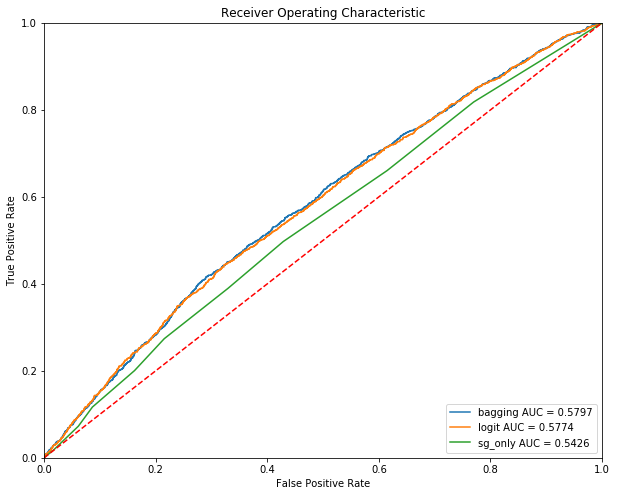

In [147]:
# ROC for all the models

# model_list = [knn_grid.best_estimator_, 
#               logistic_grid.best_estimator_, 
#               svm_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['knn', 'logit', 'svm', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for just the FASTEST models

# model_list = [logistic_grid.best_estimator_, 
#               gnb_best, 
#               rf_grid.best_estimator_,
#               'ensemble',
#               logistic_sub_grade,
#               dummy]
# model_name = ['logit', 'n_bayes', 'random_forest', 'ensemble', 'sg_only', 'dummy']

# ROC for testing

#model_list = [gboost,
#              bagging_logit,
#              logistic_grid.best_estimator_,
#              rf_grid.best_estimator_,
#              logistic_sub_grade,
#              dummy]
#model_name = ['gboost', 'bagging', 'logit', 'rand_forest', 'sg_only', 'dummy']

# model_list = [bagging_logit,
#               logistic_grid.best_estimator_,
#               rf_grid.best_estimator_,
#               gnb,
#               'ensemble',
#               logistic_sub_grade]
# model_name = ['bagging', 'logit', 'rand_forest', 'naive_bayes', 'ensemble', 'sg_only']

model_list = [bagging_logit,
              logistic_grid.best_estimator_,
              logistic_sub_grade]
model_name = ['bagging', 'logit', 'sg_only']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.50
        w2 = 0.50
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(x_norm_val)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(x_norm_val)[:,1]
                  + (1-w1-w2)*gnb_best.predict_proba(x_norm_val)[:,1])
        
    elif model == logistic_sub_grade:
        y_pred = list(model.predict_proba(x_patsy_sg_val)[:,1])
    else:
        y_pred = list(model.predict_proba(x_norm_val)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [104]:
# Examine the correlation of the model errors

#knn_error = y_train - knn_grid.predict_proba(x_norm_train)[:,1]
logit_error = y_train - logistic_grid.predict_proba(x_norm_train)[:,1]
#svm_error = y_train - svm_grid.predict_proba(x_norm_train)[:,1]
gnb_error = y_train - gnb_best.predict_proba(x_norm_train)[:,1]
rf_error = y_train - rf_grid.predict_proba(x_norm_train)[:,1]

error_df = pd.DataFrame()
#error_df['knn'] = knn_error
error_df['logit'] = logit_error
#error_df['svm'] = svm_error
error_df['gnb'] = gnb_error
error_df['rand_forest'] = rf_error

error_df.corr()

,logit,gnb,rand_forest
logit,1.000000,0.937316,0.989708
gnb,0.937316,1.000000,0.935887
rand_forest,0.989708,0.935887,1.000000


In [120]:
# Set cutoff by trading off between recall and precision (confusion matrix)

cutoff = 0.18
y_pred = rf_grid.best_estimator_.predict_proba(x_norm_val)

y_class = []
for i in y_pred[:,1]:
    if i >= cutoff:
        y_class.append(1)
    else:
        y_class.append(0)
    
conf_mat = metrics.confusion_matrix(y_val, y_class)
print(conf_mat)
my_default_rate = conf_mat[1,0]/(conf_mat[0,0] + conf_mat[1,0])
total_default_rate = np.sum(conf_mat, axis=1)[1]/(np.sum(conf_mat, axis=1)[0] + np.sum(conf_mat, axis=1)[1])
print(my_default_rate, total_default_rate)

[[ 227 4263]
 [  24 1681]]
0.09561752988047809 0.27522195318805487


In [106]:
# For backtest, randomly pick baskets of 100 loans and compare their performance with 
# 100 loans picked from the loans that the model likes